# VIDEO GAME SALES PREDICTION
<b>OBJECTIVE OF PROJECT: </b> <br>
Predicting video game sales is a crucial task for game developers, publishers, and investors in
the gaming industry. The ability to forecast sales accurately helps in making informed
decisions regarding marketing strategies, production budgets, and overall business planning.
By leveraging historical data and machine learning techniques, video game sales prediction
models can provide valuable insights into the potential success of a game and assist in
optimizing various aspects of game development and marketing.

In [1]:
import numpy as np
import pandas as pd
import sklearn
import seaborn as sn
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew 
%matplotlib inline

> Let's get the data and preview the data

In [2]:
data = pd.read_csv('./Video_Games_Sales_as_at_22_Dec_2016.csv')
data.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


> Let's look at the size of the dataset

In [3]:
print(data.shape)

(16719, 16)


> Let's check for outliers between what I suspect to be, the most obvious pair of dependent and independent variables.

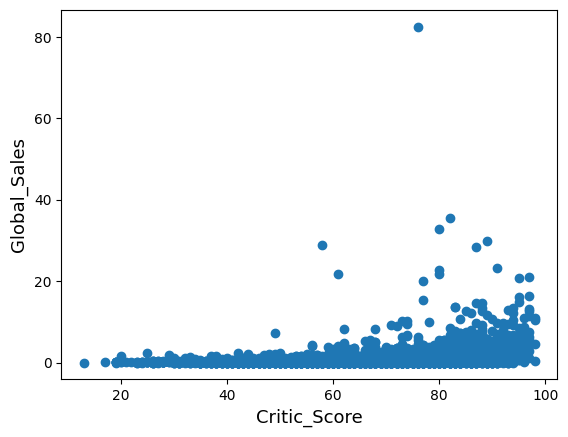

In [4]:
fig, ax = plt.subplots()
ax.scatter(x = data['Critic_Score'], y = data['Global_Sales'])
plt.ylabel('Global_Sales', fontsize=13)
plt.xlabel('Critic_Score', fontsize=13)
plt.show()

> There's really only one clear outlier in the dataset, so lets get rid of it

In [5]:
data = data.drop(data[(data['Critic_Score']>60) & (data['Global_Sales']>60)].index)

> Let's check the plot again to confirm we are rid of the outlier

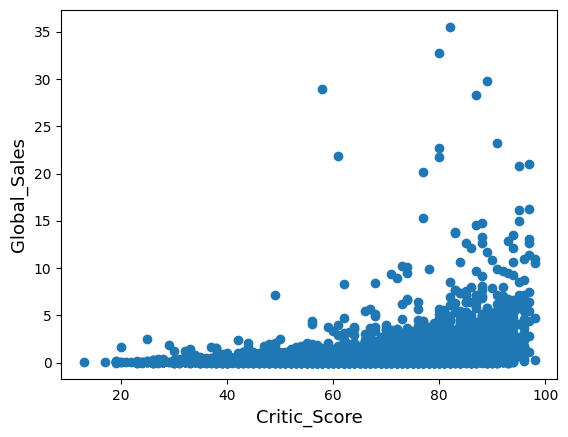

In [6]:
fig, ax = plt.subplots()
ax.scatter(x = data['Critic_Score'], y = data['Global_Sales'])
plt.ylabel('Global_Sales', fontsize=13)
plt.xlabel('Critic_Score', fontsize=13)
plt.show()

**The Target Variable**

Our dependent variable is Global_Sales, so lets explore it some more.

> Let's look at its distribution

**Feature Engineering**

Let's look at what independent variables we will keep and whether there are N/A values etc.

> Let's look at what features have N/A values

In [7]:
data_na = (data.isnull().sum() / len(data)) * 100
data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :data_na})
missing_data.head(16)

,Missing Ratio
User_Count,54.605814
Critic_Score,51.333892
Critic_Count,51.333892
Rating,40.489293
User_Score,40.100490
Developer,39.615983
Year_of_Release,1.609044
Publisher,0.323005
Name,0.011963
Genre,0.011963


In [8]:
print(pd.value_counts(data["Platform"]))

Platform
PS2     2161
DS      2152
PS3     1331
Wii     1319
X360    1262
PSP     1209
PS      1197
PC       974
XB       824
GBA      822
GC       556
3DS      520
PSV      432
PS4      393
N64      319
XOne     247
SNES     239
SAT      173
WiiU     147
2600     133
NES       98
GB        98
DC        52
GEN       29
NG        12
SCD        6
WS         6
3DO        3
TG16       2
GG         1
PCFX       1
Name: count, dtype: int64


/tmp/ipykernel_96247/2362011040.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  print(pd.value_counts(data["Platform"]))


As we can see, there are actually a lot of different platforms in the dataset. As previously mentioned, it might be most relevant to look at only current gen consoles in our model, however the issue here is that we will have a limited amount of data. Therefore, let's widen our scope somewhat and look at the following platforms: PS3, PS4, X360, XOne, PC, Wii and WiiU. This ensures that we won't have too little data. Let's keep only relevant platforms.

In [9]:
data = data[(data['Platform'] == 'PS3') | (data['Platform'] == 'PS4') | (data['Platform'] == 'X360') | (data['Platform'] == 'XOne') | (data['Platform'] == 'Wii') | (data['Platform'] == 'WiiU') | (data['Platform'] == 'PC')]

#Let's double check the value counts to be sure
print(pd.value_counts(data["Platform"]))

#Let's see the shape of the data again
print(data.shape)

#Lets see the missing ratios again
data_na = (data.isnull().sum() / len(data)) * 100
data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :data_na})
missing_data.head(16)

Platform
PS3     1331
Wii     1319
X360    1262
PC       974
PS4      393
XOne     247
WiiU     147
Name: count, dtype: int64
(5673, 16)


/tmp/ipykernel_96247/860727982.py:4: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  print(pd.value_counts(data["Platform"]))


,Missing Ratio
Critic_Score,37.493390
Critic_Count,37.493390
User_Count,34.584876
Rating,23.761678
User_Score,22.563018
Developer,21.716905
Year_of_Release,1.868500
Publisher,0.229156


So we still have almost 40 % of data points missing the critic score. This is still way too big, so let's drop all rows, that have N/A for Critic_Score. We cannot replace 40 % of the data with say, the median values. We must therefore eliminate N/A observations themselves.

In [10]:
data = data.dropna(subset=['Critic_Score'])

#Let's see the shape of the data again
print(data.shape)

#Lets see the missing ratios again
data_na = (data.isnull().sum() / len(data)) * 100
data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :data_na})
missing_data.head(16)

(3546, 16)


,Missing Ratio
User_Count,5.019741
Year_of_Release,2.002256
Rating,2.002256
User_Score,0.564016
Publisher,0.084602
Developer,0.084602


* For Publisher let's fill N/A's with the mode

In [11]:
data['Publisher'] = data['Publisher'].fillna(data['Publisher'].mode()[0])

* For Developer let's fill N/A's with the mode

In [12]:
data['Developer'] = data['Developer'].fillna(data['Developer'].mode()[0])

* For Rating let's fill N/A's with the mode

In [13]:
data['Rating'] = data['Rating'].fillna(data['Rating'].mode()[0])

* For Year_of_Release let's fill with the median value

In [14]:
data['Year_of_Release'] = data['Year_of_Release'].fillna(data['Year_of_Release'].median())

* For User_Score let's fill with the median value

In [15]:
#There's "tbd" values in the mix here which we need to handle first
data['User_Score'] = data['User_Score'].replace('tbd', None)

#Now we can handle the N/A's appropriately
data['User_Score'] = data['User_Score'].fillna(data['User_Score'].median())

* For User_Count let's fill with the median value

In [16]:
data['User_Count'] = data['User_Count'].fillna(data['User_Count'].median())

* Now let's verify that we don't have any more missing values

In [17]:
#Lets see the missing ratios again
data_na = (data.isnull().sum() / len(data)) * 100
data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :data_na})
missing_data.head(16)

,Missing Ratio


Hurray! We've dealt with all the missing values finally. Now let's deal with categorical values next. We need to change the following independent variables to dummy variables:

* Platform
* Genre
* Publisher
* Developer
* Rating

However, here we have an issue. Publisher and Developer will cause a massive influx of features as there are so many unique values in the mix. At this point it seems best to drop these features entirely.

Instead, let's only create dummies for:

* Platform
* Genre
* Rating

In [18]:
print(data.shape) #pre-dummies shape
data = pd.get_dummies(data=data, columns=['Platform', 'Genre', 'Rating'])
print(data.shape) #post-dummies shape
data.head #Check to verify that dummies are ok

(3546, 16)
(3546, 37)


<bound method NDFrame.head of                                     Name  Year_of_Release  \
2                         Mario Kart Wii           2008.0   
3                      Wii Sports Resort           2009.0   
7                               Wii Play           2006.0   
8              New Super Mario Bros. Wii           2009.0   
13                               Wii Fit           2007.0   
...                                  ...              ...   
16664                   Prison Architect           2016.0   
16696  Metal Gear Solid V: Ground Zeroes           2014.0   
16700                             Breach           2011.0   
16706            STORM: Frontline Nation           2011.0   
16709                            15 Days           2009.0   

                          Publisher  NA_Sales  EU_Sales  JP_Sales  \
2                          Nintendo     15.68     12.76      3.79   
3                          Nintendo     15.61     10.93      3.28   
7                          Nin

Great! Let's drop the features we wish to discard for our models. These include:

* Name
* Publisher
* Developer
* NA_Sales
* EU_Sales
* JP_Sales
* Other_Sales

In [19]:
data = data.drop(['Name', 'Publisher', 'Developer', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales'], axis=1)

 Let's define X and Y and then split into training and test data

In [20]:
print(data.columns) #easy to copy-paste the values to rearrange from here

X = data[['Year_of_Release', 'Critic_Score', 'Critic_Count',
       'User_Score', 'User_Count', 'Platform_PC', 'Platform_PS3',
       'Platform_PS4', 'Platform_Wii', 'Platform_WiiU', 'Platform_X360',
       'Platform_XOne', 'Genre_Action', 'Genre_Adventure', 'Genre_Fighting',
       'Genre_Misc', 'Genre_Platform', 'Genre_Puzzle', 'Genre_Racing',
       'Genre_Role-Playing', 'Genre_Shooter', 'Genre_Simulation',
       'Genre_Sports', 'Genre_Strategy', 'Rating_E', 'Rating_E10+', 'Rating_M',
       'Rating_RP', 'Rating_T']]

Y = data[['Global_Sales']]

#Double checking the shape
print(X.shape)
print(Y.shape)

Index(['Year_of_Release', 'Global_Sales', 'Critic_Score', 'Critic_Count',
       'User_Score', 'User_Count', 'Platform_PC', 'Platform_PS3',
       'Platform_PS4', 'Platform_Wii', 'Platform_WiiU', 'Platform_X360',
       'Platform_XOne', 'Genre_Action', 'Genre_Adventure', 'Genre_Fighting',
       'Genre_Misc', 'Genre_Platform', 'Genre_Puzzle', 'Genre_Racing',
       'Genre_Role-Playing', 'Genre_Shooter', 'Genre_Simulation',
       'Genre_Sports', 'Genre_Strategy', 'Rating_E', 'Rating_E10+', 'Rating_M',
       'Rating_RP', 'Rating_T'],
      dtype='object')
(3546, 29)
(3546, 1)


In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=42)

#Let's check the shape of the split data as a precaution
print("X_train shape: {}".format(X_train.shape))
print("Y_train shape: {}".format(Y_train.shape))

print("X_test shape: {}".format(X_test.shape))
print("Y_test shape: {}".format(Y_test.shape))

X_train shape: (2659, 29)
Y_train shape: (2659, 1)
X_test shape: (887, 29)
Y_test shape: (887, 1)


Now that we have the test split into training and test data we can still do some final scaling of the data before fitting the models. 

As mentioned previously, lets do a log-transformation of the dependent variable in both the training and test data.

In [22]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
Y_train = np.log1p(Y_train)
Y_test = np.log1p(Y_test)


 mu = 0.43 and sigma = 0.48



/tmp/ipykernel_96247/125832626.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(Y_log_transformed , fit=norm);
/home/evaface/miniconda3/envs/tensorflow/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/evaface/miniconda3/envs/tensorflow/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.op

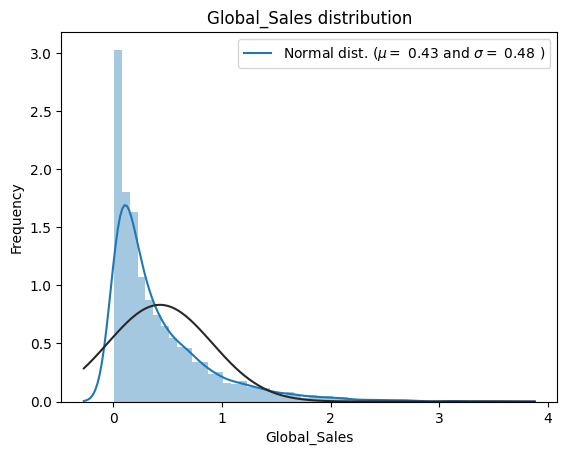

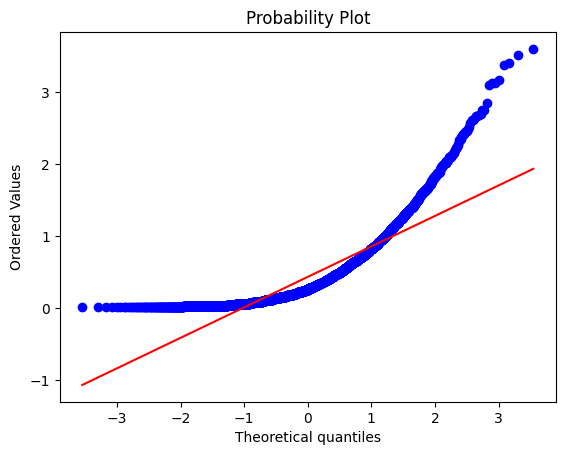

In [23]:
#Check the new distribution 
Y_log_transformed = np.log1p(data['Global_Sales']) #For comparison to earlier, here's the whole Y transformed
sns.distplot(Y_log_transformed , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(Y_log_transformed)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Global_Sales distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(Y_log_transformed, plot=plt)
plt.show()


As we can see, the log-transformation didn't do too much to help us normalize the data. To be honest, this step might not be all that useful, especially if we choose to fit models that can handle non-linear data pretty well. None the less, not much harm done either, so let's proceed.

Let's fit X_train and scale X_train and X_test with the MinMax Scaler to get all independent variables in a similar range.

In [24]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train) 
X_test_scaled = scaler.transform(X_test)

Now we are really close to the fun part. First however, we need to prepare our grids for grid search. For this, we need to decide, which models we will use. So let's try:

* Linear Regression
* Lasso
* Ridge Regression
* Support Vector Regressor
* Random Forest
* Gradient Boosting Regressor
* MLP Regressor a.k.a. a Neural Network

In [25]:
#No grid to define for vanilla linear regression
param_grid_lr = [
    {}
]

#Parameter grid for lasso
param_grid_lasso = [
    {'alpha': [10, 1, 0.1, 0.01, 0.001, 0.0001], 'max_iter': [1000000, 100000, 10000, 1000]}
]

#Parameter grid for Ridge Regression
param_grid_rr = [
    {'alpha': [100, 10, 1, 0.1, 0.01, 0.001]}
]

#Parameter grid for Support Vector Regressor
param_grid_svr = [
    {'C': [0.01, 0.1, 1, 10], 'gamma': [0.0001, 0.001, 0.01, 0.1, 1],
     'kernel': ['rbf']}
]

#Parameter grid for Random Forest
param_grid_rf = [
    {'n_estimators': [3, 10, 30, 50, 70], 'max_features': [2,4,6,8,10,12], 'max_depth': [2, 3, 5, 7, 9]}
]

#Parameter grid for Gradient Boosting Regressor
param_grid_gbr = [
    {'n_estimators': [200, 225, 250, 275], 'max_features': [6, 8, 10, 12], 'max_depth': [5, 7, 9]}
]

#Parameter grid for MLPRegressor. 
#Current set of hyperparameters are the result of grid search that took forever.
param_grid_mlpr = [
    {'hidden_layer_sizes': [(10,5)], 'solver': ['lbfgs'], 'batch_size': [200],
     'learning_rate': ['adaptive'], 'max_iter': [800], 'verbose': [True], 
     'nesterovs_momentum': [True], 'early_stopping': [True], 'validation_fraction': [0.12],
     'random_state': [100], 'alpha': [0.1], 'activation': ['logistic']}
]

Now that we have the parameter grids, let's implement the models one by one and see which does the best. 

Let's use RMSE for scoring the models. The interpretation for RMSE, or Root Mean Squared Error, is more intuitive than that of the MSE as RMSE is an absolute measure of fit. It thus tells us our error in actual sales units. Also, to quote theanalysisfactor.com: "RMSE is a good measure of how accurately the model predicts the response, and is the most important criterion for fit if the main purpose of the model is prediction."

However, before interpreting the RMSE, we must also do an exp transformation on the RMSE scores to undo the log transformation and for the results to be more easily interpreted. Otherwise the RMSE will be in log(Global_Sales).

In conjunction with our grid search, let's use cross-validation with 5 folds.

In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

grid_search_lr = GridSearchCV(LinearRegression(), param_grid_lr, scoring='neg_mean_squared_error',  cv=5)
grid_search_lr.fit(X_train, Y_train)
print("Best parameters: {}".format(grid_search_lr.best_params_))
lr_best_cross_val_score = (np.sqrt(-grid_search_lr.best_score_))
print("Best cross-validation score: {:.2f}".format(np.expm1(lr_best_cross_val_score)))
lr_score = np.sqrt(-grid_search_lr.score(X_test, Y_test))
print("Test set score: {:.2f}".format(np.expm1(lr_score)))

Best parameters: {}
Best cross-validation score: 0.41
Test set score: 0.43


In [27]:
from sklearn.linear_model import Lasso

grid_search_lasso = GridSearchCV(Lasso(), param_grid_lasso, cv=5, scoring='neg_mean_squared_error')
grid_search_lasso.fit(X_train, Y_train)
print("Best parameters: {}".format(grid_search_lasso.best_params_))
lasso_best_cross_val_score = (np.sqrt(-grid_search_lasso.best_score_))
print("Best cross-validation score: {:.2f}".format(np.expm1(lasso_best_cross_val_score)))
lasso_score = np.sqrt(-grid_search_lasso.score(X_test, Y_test))
print("Test set score: {:.2f}".format(np.expm1(lasso_score)))

Best parameters: {'alpha': 0.0001, 'max_iter': 1000000}
Best cross-validation score: 0.41
Test set score: 0.43


In [28]:
from sklearn.linear_model import Ridge

grid_search_rr = GridSearchCV(Ridge(), param_grid_rr, cv=5, scoring='neg_mean_squared_error')
grid_search_rr.fit(X_train, Y_train)
print("Best parameters: {}".format(grid_search_rr.best_params_))
rr_best_cross_val_score = (np.sqrt(-grid_search_rr.best_score_))
print("Best cross-validation score: {:.2f}".format(np.expm1(rr_best_cross_val_score)))
rr_score = np.sqrt(-grid_search_rr.score(X_test, Y_test))
print("Test set score: {:.2f}".format(np.expm1(rr_score)))

Best parameters: {'alpha': 10}
Best cross-validation score: 0.41
Test set score: 0.43


In [29]:
from sklearn.neural_network import MLPRegressor

grid_search_mlpr = GridSearchCV(MLPRegressor(), param_grid_mlpr, cv=5, scoring='neg_mean_squared_error')
grid_search_mlpr.fit(X_train, Y_train)
print("Best parameters: {}".format(grid_search_mlpr.best_params_))
mlpr_best_cross_val_score = (np.sqrt(-grid_search_mlpr.best_score_))
print("Best cross-validation score: {:.2f}".format(np.expm1(mlpr_best_cross_val_score)))
mlpr_score = np.sqrt(-grid_search_mlpr.score(X_test, Y_test))
print("Test set score: {:.2f}".format(np.expm1(mlpr_score)))

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          361     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.85335D-01    |proj g|=  7.32112D-01

At iterate    1    f=  1.17307D-01    |proj g|=  3.93073D-02

At iterate    2    f=  1.15967D-01    |proj g|=  1.04650D-02

At iterate    3    f=  1.15820D-01    |proj g|=  8.07627D-02

At iterate    4    f=  1.15762D-01    |proj g|=  4.61506D-02

At iterate    5    f=  1.15591D-01    |proj g|=  2.40245D-02

At iterate    6    f=  1.14541D-01    |proj g|=  1.75243D-01

At iterate    7    f=  1.12988D-01    |proj g|=  1.79656D-01

At iterate    8    f=  1.10248D-01    |proj g|=  2.90063D-01

At iterate    9    f=  1.05854D-01    |proj g|=  2.79119D-01

At iterate   10    f=  1.04696D-01    |proj g|=  3.62482D-01

At iterate   11    f=  1.00712D-01    |proj g|=  6.52752D-02

At iterate   12    f=  1.00325D-01    |proj g|=  6.91349D-02

At iterate   13    f=  9.9

/home/evaface/miniconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1625: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 This problem is unconstrained.



At iterate   18    f=  9.78825D-02    |proj g|=  2.82240D-02

At iterate   19    f=  9.78038D-02    |proj g|=  6.73547D-02

At iterate   20    f=  9.77687D-02    |proj g|=  2.79001D-02

At iterate   21    f=  9.77593D-02    |proj g|=  1.99502D-02

At iterate   22    f=  9.77517D-02    |proj g|=  2.18227D-02

At iterate   23    f=  9.77388D-02    |proj g|=  7.85707D-03

At iterate   24    f=  9.77241D-02    |proj g|=  2.31209D-02

At iterate   25    f=  9.76980D-02    |proj g|=  4.32118D-02

At iterate   26    f=  9.70915D-02    |proj g|=  5.22018D-01

At iterate   27    f=  9.65414D-02    |proj g|=  2.35474D-01

At iterate   28    f=  9.63832D-02    |proj g|=  6.78453D-02

At iterate   29    f=  9.60829D-02    |proj g|=  4.78744D-02

At iterate   30    f=  9.44016D-02    |proj g|=  2.93695D-01

At iterate   31    f=  9.42784D-02    |proj g|=  3.91682D-01

At iterate   32    f=  9.38505D-02    |proj g|=  1.07295D-01

At iterate   33    f=  9.37251D-02    |proj g|=  1.41082D-01

At iter

/home/evaface/miniconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/evaface/miniconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1625: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 This problem is unconstrained.



At iterate    4    f=  1.09523D-01    |proj g|=  5.22808D-02

At iterate    5    f=  1.09509D-01    |proj g|=  1.28171D-02

At iterate    6    f=  1.09476D-01    |proj g|=  1.37861D-02

At iterate    7    f=  1.09412D-01    |proj g|=  1.77044D-02

At iterate    8    f=  1.07361D-01    |proj g|=  1.75477D-01

At iterate    9    f=  1.02813D-01    |proj g|=  4.82966D-02

At iterate   10    f=  9.78700D-02    |proj g|=  2.14571D-01

At iterate   11    f=  9.57683D-02    |proj g|=  4.64169D-02

At iterate   12    f=  9.57518D-02    |proj g|=  3.82567D-02

At iterate   13    f=  9.54335D-02    |proj g|=  1.90632D-01

At iterate   14    f=  9.52569D-02    |proj g|=  2.31553D-01

At iterate   15    f=  9.50336D-02    |proj g|=  1.10878D-01

At iterate   16    f=  9.48296D-02    |proj g|=  1.78500D-02

At iterate   17    f=  9.47450D-02    |proj g|=  2.27133D-02

At iterate   18    f=  9.47345D-02    |proj g|=  8.02018D-02

At iterate   19    f=  9.46862D-02    |proj g|=  1.56839D-01

At iter

/home/evaface/miniconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/evaface/miniconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1625: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 This problem is unconstrained.



At iterate    2    f=  1.06326D-01    |proj g|=  3.35965D-02

At iterate    3    f=  1.06251D-01    |proj g|=  8.63206D-02

At iterate    4    f=  1.05773D-01    |proj g|=  5.34995D-02

At iterate    5    f=  1.05470D-01    |proj g|=  2.37693D-01

At iterate    6    f=  1.05140D-01    |proj g|=  4.82136D-02

At iterate    7    f=  1.03099D-01    |proj g|=  1.13166D-01

At iterate    8    f=  9.30938D-02    |proj g|=  6.37152D-02

At iterate    9    f=  8.99725D-02    |proj g|=  2.51973D-01

At iterate   10    f=  8.96538D-02    |proj g|=  2.11803D-01

At iterate   11    f=  8.94227D-02    |proj g|=  1.64568D-01

At iterate   12    f=  8.93452D-02    |proj g|=  6.39182D-02

At iterate   13    f=  8.91690D-02    |proj g|=  2.20471D-02

At iterate   14    f=  8.91515D-02    |proj g|=  5.35564D-03

At iterate   15    f=  8.91434D-02    |proj g|=  1.29659D-02

At iterate   16    f=  8.91313D-02    |proj g|=  2.73693D-02

At iterate   17    f=  8.91304D-02    |proj g|=  2.63297D-02

At iter

/home/evaface/miniconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/evaface/miniconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1625: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 This problem is unconstrained.



At iterate   25    f=  7.94987D-02    |proj g|=  1.28680D-01

At iterate   26    f=  7.94108D-02    |proj g|=  2.30328D-01

At iterate   27    f=  7.92374D-02    |proj g|=  1.58961D-01

At iterate   28    f=  7.91910D-02    |proj g|=  4.85020D-02

At iterate   29    f=  7.91749D-02    |proj g|=  3.21609D-02

At iterate   30    f=  7.91499D-02    |proj g|=  1.60232D-01

At iterate   31    f=  7.90645D-02    |proj g|=  2.83069D-01

At iterate   32    f=  7.90405D-02    |proj g|=  5.91354D-02

At iterate   33    f=  7.90232D-02    |proj g|=  1.83751D-02

At iterate   34    f=  7.90214D-02    |proj g|=  6.72578D-02

At iterate   35    f=  7.90201D-02    |proj g|=  2.82147D-02

At iterate   36    f=  7.90187D-02    |proj g|=  4.43110D-03

At iterate   37    f=  7.90175D-02    |proj g|=  6.56778D-03

At iterate   38    f=  7.90060D-02    |proj g|=  3.79174D-02

At iterate   39    f=  7.90050D-02    |proj g|=  2.47792D-02

At iterate   40    f=  7.90024D-02    |proj g|=  5.57310D-03

At iter

/home/evaface/miniconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/evaface/miniconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1625: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 This problem is unconstrained.



At iterate    2    f=  1.08189D-01    |proj g|=  3.16845D-02

At iterate    3    f=  1.08019D-01    |proj g|=  1.00164D-02

At iterate    4    f=  1.08010D-01    |proj g|=  2.07357D-02

At iterate    5    f=  1.07921D-01    |proj g|=  9.09294D-03

At iterate    6    f=  1.05689D-01    |proj g|=  2.46200D-01

At iterate    7    f=  9.63028D-02    |proj g|=  3.43890D-01

At iterate    8    f=  9.49489D-02    |proj g|=  5.39930D-01

At iterate    9    f=  9.24253D-02    |proj g|=  1.38413D-01

At iterate   10    f=  9.21272D-02    |proj g|=  2.24187D-02

At iterate   11    f=  9.21251D-02    |proj g|=  2.02064D-02

At iterate   12    f=  9.21221D-02    |proj g|=  3.24777D-03

At iterate   13    f=  9.21208D-02    |proj g|=  7.59071D-03

At iterate   14    f=  9.21185D-02    |proj g|=  1.23997D-02

At iterate   15    f=  9.21067D-02    |proj g|=  2.69974D-02

At iterate   16    f=  9.20809D-02    |proj g|=  4.57156D-02

At iterate   17    f=  9.20094D-02    |proj g|=  7.76128D-02

At iter

/home/evaface/miniconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1625: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 This problem is unconstrained.



At iterate    2    f=  1.08373D-01    |proj g|=  1.04127D-02

At iterate    3    f=  1.08367D-01    |proj g|=  2.50351D-02

At iterate    4    f=  1.08214D-01    |proj g|=  1.26175D-02

At iterate    5    f=  1.07345D-01    |proj g|=  2.68271D-02

At iterate    6    f=  1.04377D-01    |proj g|=  5.46639D-02

At iterate    7    f=  9.91852D-02    |proj g|=  2.14196D+00

At iterate    8    f=  9.82000D-02    |proj g|=  6.15507D-02

At iterate    9    f=  9.51517D-02    |proj g|=  1.06549D+00

At iterate   10    f=  9.46187D-02    |proj g|=  4.52497D-02

At iterate   11    f=  9.27709D-02    |proj g|=  7.31529D-02

At iterate   12    f=  9.09464D-02    |proj g|=  6.69219D-02

At iterate   13    f=  8.98721D-02    |proj g|=  9.82892D-02

At iterate   14    f=  8.91741D-02    |proj g|=  3.28315D-01

At iterate   15    f=  8.89533D-02    |proj g|=  3.07786D-01

At iterate   16    f=  8.89105D-02    |proj g|=  1.99704D-01

At iterate   17    f=  8.87558D-02    |proj g|=  7.31363D-02

At iter

/home/evaface/miniconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


So the best model out of the seven we trained is the GBR!